In [1]:
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(5)  # Number of cores
tf.config.threading.set_intra_op_parallelism_threads(5)

In [2]:
import numpy as np
arr1 = np.load('combined_array.npy')
arr2= np.load('combined_labels.npy')

In [3]:
arr1.shape,arr2.shape
# here we loaded 13711 imagess each with 300x300 pixels which is of rgb type ( 3 channels )

((13711, 256, 256, 3), (13711,))

In [4]:
arr1[0][0].shape

(256, 3)

In [5]:
un=np.unique(arr2)
len(un) # 23 lables

23

In [6]:
ani=['Clams','Corals','Crabs','Dolphin','Eel','Fish','Jelly','Lobster','Nudibranchs','Octopus','Otter','Penguin','Puffers','Sea_Rays','Sea_Urchins','Seahorse','Seal','Sharks','Shrimps','Squid','Starfish','Turtle','Whale']
len(ani)

23

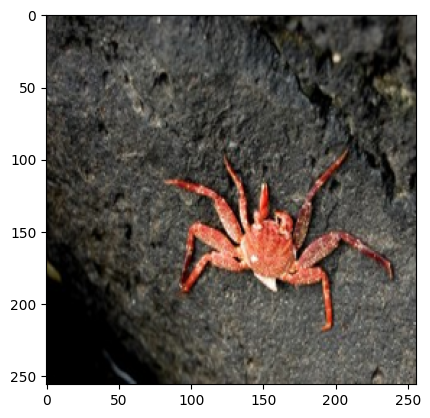

In [7]:
# displaying random images from the data
import matplotlib.pyplot as plt
i = np.random.randint(0,arr1.shape[0])
plt.imshow(arr1[i])

In [8]:
arr1=arr1[:5000]
arr2=arr2[:5000]
arr1.shape,arr2.shape

((5000, 256, 256, 3), (5000,))

In [9]:
# splitting the data into train,validation and test (60-20-20)%

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(arr1,arr2, test_size=0.4, random_state=42)
x_val,x_test,y_val,y_test=train_test_split(x_temp,y_temp,test_size=0.5,random_state=42)
print(x_train.shape,y_train.shape) # train data
print(x_val.shape,y_val.shape) # validation data
print(x_test.shape,y_test.shape) # test data

(3000, 256, 256, 3) (3000,)
(1000, 256, 256, 3) (1000,)
(1000, 256, 256, 3) (1000,)


In [11]:
# we must convert our validation_data and testdata to onehot encoding
# why? 
"""
Most neural networks expect the target labels to be in a one-hot encoded format, especially when using the softmax activation function in the output layer for multiclass
classification. The softmax function outputs a probability distribution over the classes, and the network compares this with the one-hot encoded labels to compute the loss
 (e.g., categorical crossentropy).
"""

'\nMost neural networks expect the target labels to be in a one-hot encoded format, especially when using the softmax activation function in the output layer for multiclass\nclassification. The softmax function outputs a probability distribution over the classes, and the network compares this with the one-hot encoded labels to compute the loss\n (e.g., categorical crossentropy).\n'

In [12]:
from tensorflow.keras.utils import to_categorical
y_train_hot=to_categorical(y_train-1)
y_val_hot=to_categorical(y_val-1)
y_test_hot=to_categorical(y_test-1)

In [13]:
y_train_hot.shape,y_val_hot.shape,y_test_hot.shape

((3000, 9), (1000, 9), (1000, 9))

In [14]:
"""
As the images are already diverse, there is no need for much augumentation , however small agumentations like imageflipping,image ratation or
brightness adjustment can be performed 

Data augumentation increases the variability in the data and ensure the model is robust and generalize well on unseen data

"""

'\nAs the images are already diverse, there is no need for much augumentation , however small agumentations like imageflipping,image ratation or\nbrightness adjustment can be performed \n\nData augumentation increases the variability in the data and ensure the model is robust and generalize well on unseen data\n\n'

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotate images by up to 20 degrees
    width_shift_range=0.2,     # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Shift images vertically by up to 20% of the height      
    zoom_range=0.2,            # Zoom in or out by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill missing pixels after transformation
)

# Fit the data generator on your training data
datagen.fit(x_train[:5000])

In [16]:
"""
For each image in your dataset, ImageDataGenerator can produce a different variation each time the image is used in a training batch. 
This means that over multiple epochs, the model will see multiple different variations of each original image.

While the model primarily sees variations, it could also see the original image if the applied augmentations result in minimal or no transformation 
(e.g., if the random rotation happens to be 0 degrees or the flip doesn't occur).

"""

"\nFor each image in your dataset, ImageDataGenerator can produce a different variation each time the image is used in a training batch. \nThis means that over multiple epochs, the model will see multiple different variations of each original image.\n\nWhile the model primarily sees variations, it could also see the original image if the applied augmentations result in minimal or no transformation \n(e.g., if the random rotation happens to be 0 degrees or the flip doesn't occur).\n\n"

In [17]:
x_train.shape,x_val.shape

((3000, 256, 256, 3), (1000, 256, 256, 3))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(256,256,3))) # channel is 3 for rgb image 
model.add(MaxPooling2D(2,2))
#model.add(Dropout((0.2)))
model.add(Conv2D(64,(3,3),activation='relu')) 
model.add(MaxPooling2D(2,2))
#model.add(Dropout((0.2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
#model.add(Dropout((0.35)))  // dropout layer is preferred here if the model is overfitting
model.add(Dense(9,activation='softmax'))

# increase the dropout fraction if your model is overfitting 

C:\Users\vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#32,64,64,9 ( 20epochs-0.4 acc)

In [19]:
"""
As the network goes deeper, pooling layers (like MaxPooling) often reduce the spatial dimensions of the feature maps. To compensate for this reduction and to maintain a 
strong representation of the image data, the network increases the number of filters.
This helps the network retain and process more information even as the spatial dimensions shrink. 

"""

'\nAs the network goes deeper, pooling layers (like MaxPooling) often reduce the spatial dimensions of the feature maps. To compensate for this reduction and to maintain a \nstrong representation of the image data, the network increases the number of filters.\nThis helps the network retain and process more information even as the spatial dimensions shrink. \n\n'

In [20]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [25]:
history = model.fit(datagen.flow(x_train,y_train_hot,batch_size=32),epochs=20,validation_data=(x_val,y_val_hot)) 

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 99s 918ms/step - accuracy: 0.3779 - loss: 1.7541 - val_accuracy: 0.3890 - val_loss: 1.7309
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 896ms/step - accuracy: 0.3802 - loss: 1.7327 - val_accuracy: 0.4000 - val_loss: 1.6646
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 855ms/step - accuracy: 0.4016 - loss: 1.6942 - val_accuracy: 0.4240 - val_loss: 1.6374
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 937ms/step - accuracy: 0.3949 - loss: 1.6826 - val_accuracy: 0.4170 - val_loss: 1.6876
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 865ms/step - accuracy: 0.4062 - loss: 1.6757 - val_accuracy: 0.4150 - val_loss: 1.6545
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 869ms/step - accuracy: 0.3835 - loss: 1.6904 - val_accuracy: 0.4140 - val_loss: 1.6515
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 870ms/step - accuracy: 0.4273 - loss: 1.6242 - val_accuracy: 0.4420 - val_loss: 1.6292
Epoch 8/20
20/94 ━━━━━━━━━━━━━━━━━━━━ 1:01 826ms/step - accuracy: 0.4338 - loss: 1.6132

KeyboardInterrupt: 

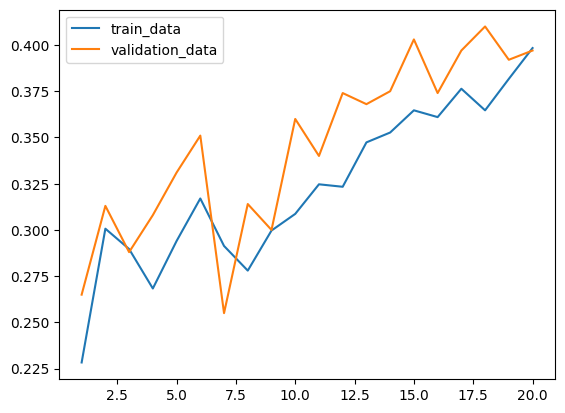

In [24]:
import matplotlib.pyplot as plt
epochs = [i for i in range(1,21)]
plt.plot(epochs,history.history['accuracy'],label='train_data')
plt.plot(epochs,history.history['val_accuracy'],label='validation_data')
plt.legend()
plt.show()